# モジュールのインポート

In [36]:
import re
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline
import shap
shap.initjs()

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import openpyxl
from openpyxl.drawing.line import LineProperties
from openpyxl.chart.shapes import GraphicalProperties
from openpyxl.chart.text import RichText
from openpyxl.drawing.text import Paragraph, ParagraphProperties, CharacterProperties, Font

# データの読み込み

In [6]:
# dataframe_path = r'C:\Users\west7\OneDrive\デスクトップ\raman処理用\\'
dataframe_path = r'C:\Users\r-swx\OneDrive\デスクトップ\raman_data\\'

dataframe_title = 'CH3_NH2'

data_df = pd.read_pickle(dataframe_path + dataframe_title + '.pkl')
data_df.head()

Raman Shift,201.192791188876,203.237476388369,205.281479548654,207.324801000766,209.367441075527,211.409400103543,213.450678415207,215.491276340697,217.53119420998,219.570432352812,...,1994.36035611163,1995.84667029798,1997.33255467823,1998.81800943131,2000.30303473604,2001.78763077115,2003.27179771526,2004.7555357469,2006.2388450445,label
CH3-NH2_1-0_01,0.010094,0.005278,0.003423,0.003786,0.009829,0.014712,0.008375,0.021651,0.025604,0.020812,...,0.029108,0.031971,0.029640,0.029288,0.029841,0.032126,0.030535,0.029109,0.029991,0.0
CH3-NH2_1-0_02,0.009815,0.008779,0.013592,0.009174,0.011729,0.005775,0.014335,0.025457,0.021731,0.021930,...,0.025704,0.025681,0.026058,0.026837,0.027053,0.025022,0.026762,0.026255,0.026630,0.0
CH3-NH2_1-0_03,0.013626,0.005049,0.001629,0.009840,0.004733,0.000274,0.008392,0.016940,0.018934,0.019103,...,0.032237,0.033024,0.033666,0.033507,0.032766,0.032533,0.033100,0.031630,0.032488,0.0
CH3-NH2_1-0_04,0.016466,0.014231,0.018497,0.016416,0.016141,0.018167,0.018293,0.020720,0.027671,0.018640,...,0.037542,0.035394,0.034481,0.034062,0.035371,0.035198,0.035601,0.036416,0.036406,0.0
CH3-NH2_1-0_05,0.004841,0.003371,0.006195,0.001817,0.003844,0.005160,0.005765,0.010586,0.016103,0.017156,...,0.028002,0.028220,0.028828,0.028341,0.028010,0.028773,0.028988,0.027092,0.030199,0.0


# モデルでの計算

In [9]:
# 特徴量とラベルの分離
data_label = data_df['label']
data_df = data_df.drop('label', axis=1)

In [18]:
X = data_df
X.columns = [str(i) for i in data_df.columns]
y = data_label

train_X, test_X, train_y, test_y = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1234)

MLP_model = MLPClassifier(hidden_layer_sizes=(100, 100),
                            activation='logistic', # logistic, tanh, relu
                            solver='adam',
                            max_iter=1000,
                            random_state=1234)
MLP_model.fit(train_X, train_y)

y_pred = MLP_model.predict(test_X)

# 正解率
Accuracy = accuracy_score(test_y, y_pred)
print('Accuracy:', Accuracy)

Accuracy: 1.0


# SHAP解析

In [101]:
explainer = shap.KernelExplainer(MLP_model.predict, test_X)
shap_values = explainer.shap_values(test_X)

shap_df = pd.DataFrame(shap_values,
                       columns=test_X.columns,
                       index=test_X.index)

100%|██████████| 50/50 [11:33<00:00, 13.87s/it]


In [54]:
# shapの絶対値の平均値をExcel形式で保存
abs_mean_shap_df = shap_df.apply(np.abs).mean()
abs_mean_shap_df.index = abs_mean_shap_df.index.astype(float)

graph_title = 'shap_CH3_NH2'
# excelファイルの保存先のパス
# excel_path = r'C:\Users\west7\OneDrive\デスクトップ\raman処理用\\'
excel_path = r'C:\Users\r-swx\OneDrive\デスクトップ\raman_data\\'
abs_mean_shap_df.to_excel(excel_path + graph_title + '.xlsx')

## Global

<AxesSubplot:>

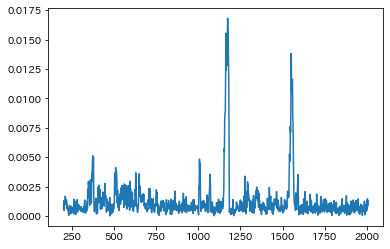

In [60]:
abs_mean_shap_df.plot()

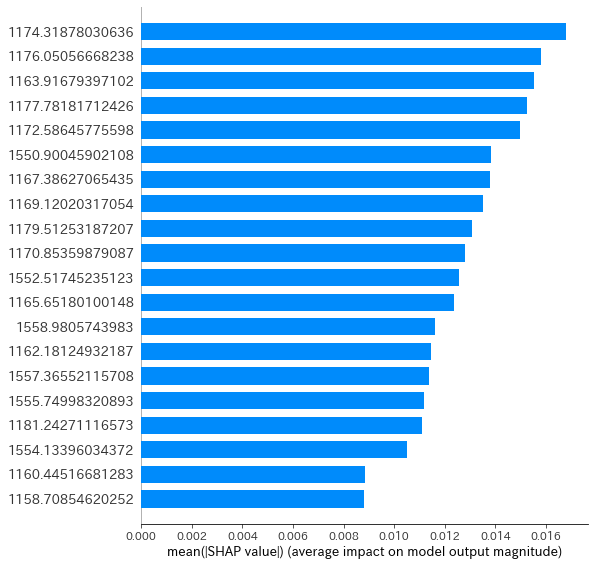

In [44]:
# shap.plots.bar(shap_values, max_display=10, order=shap.Explanation.abs)
shap.summary_plot(shap_values, test_X, plot_type="bar")

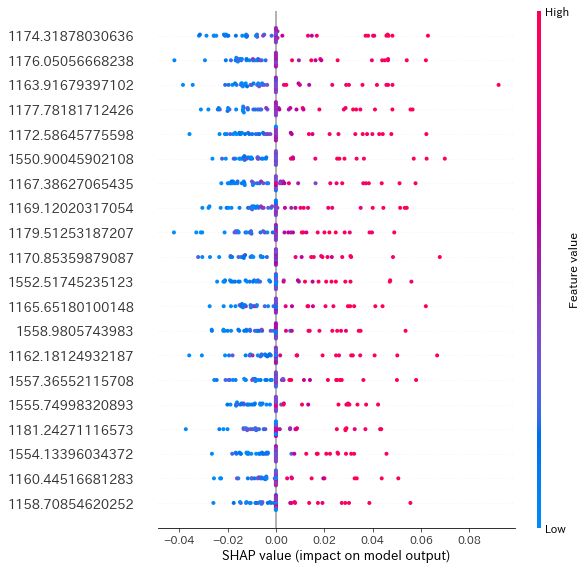

In [32]:
shap.summary_plot(shap_values, test_X)

In [37]:
shap.force_plot(explainer.expected_value, shap_values, test_X)

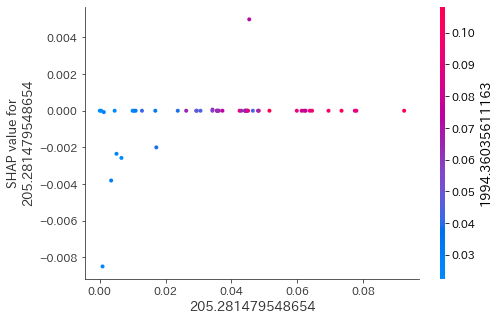

In [49]:
shap.dependence_plot(ind="205.281479548654", interaction_index="1994.36035611163", shap_values=shap_values, features=test_X)

## Local

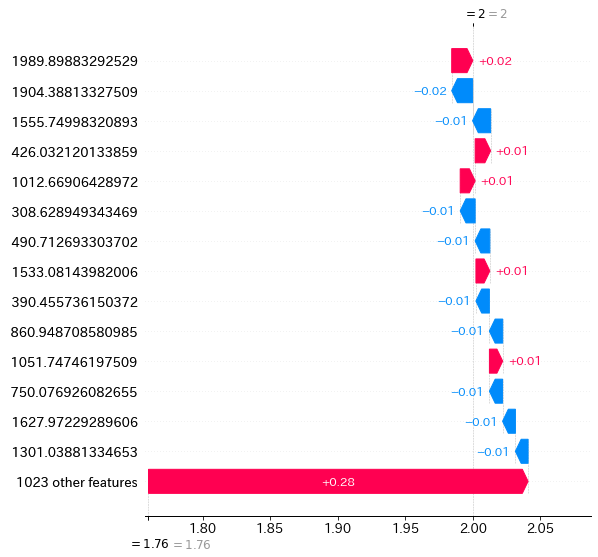

In [100]:
n = 10

exp = shap.Explanation(shap_values, explainer.expected_value, data=test_X.values, feature_names=test_X.columns)
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[n], test_X.iloc[n], max_display=15)